<a href="https://colab.research.google.com/github/joaoSouza2121/pln/blob/main/Word2vec_Usando_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Machine Learning

##Previsão de Palavras com Base no Contexto e Visualização com PCA

In [1]:
!pip install -q scikit-plot

In [2]:
# Imports
import torch
import scipy
import sklearn
import scikitplot
import numpy as np
import torch.nn.functional as F
from torch.optim import SGD
from torch.autograd import Variable, profiler
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine
from scikitplot.decomposition import plot_pca_2d_projection
%matplotlib inline


# Preparação dos Dados

In [3]:
# Corpus
corpus = ['ele é um rei',
          'ela é uma rainha',
          'ele é um homem',
          'ela é uma mulher',
          'Madrid é a capital da Espanha',
          'Berlim é a capital da Alemanha',
          'Lisboa é a capital de Portugal']


In [4]:
# Construindo o vocabulário com tokenização
palavras = []
for sentence in corpus:
    for palavra in sentence.split():
         if palavra not in palavras:
            palavras.append(palavra)


In [5]:
# Visualiza os dados
palavras

['ele',
 'é',
 'um',
 'rei',
 'ela',
 'uma',
 'rainha',
 'homem',
 'mulher',
 'Madrid',
 'a',
 'capital',
 'da',
 'Espanha',
 'Berlim',
 'Alemanha',
 'Lisboa',
 'de',
 'Portugal']

In [6]:
# Criamos o mapeamento palavra - índice  
word2idx = {w:idx for (idx, w) in enumerate(palavras)}
word2idx


{'Alemanha': 15,
 'Berlim': 14,
 'Espanha': 13,
 'Lisboa': 16,
 'Madrid': 9,
 'Portugal': 18,
 'a': 10,
 'capital': 11,
 'da': 12,
 'de': 17,
 'ela': 4,
 'ele': 0,
 'homem': 7,
 'mulher': 8,
 'rainha': 6,
 'rei': 3,
 'um': 2,
 'uma': 5,
 'é': 1}

In [7]:
# Criamos o mapeamento inverso índice - palavra
idx2word = {idx:w for (idx, w) in enumerate(palavras)}
idx2word


{0: 'ele',
 1: 'é',
 2: 'um',
 3: 'rei',
 4: 'ela',
 5: 'uma',
 6: 'rainha',
 7: 'homem',
 8: 'mulher',
 9: 'Madrid',
 10: 'a',
 11: 'capital',
 12: 'da',
 13: 'Espanha',
 14: 'Berlim',
 15: 'Alemanha',
 16: 'Lisboa',
 17: 'de',
 18: 'Portugal'}

In [8]:
# Tamanho do vocabulário
tamanho_vocab = len(word2idx)
tamanho_vocab


19

##Construção do Modelo

In [9]:
# Função para gerar os embeddings
def get_word_embedding(word):
    word_vec_one_hot = np.zeros(tamanho_vocab)
    word_vec_one_hot[word2idx[word]] = 1
    return word_vec_one_hot


In [10]:
# Função para gerar os vetores, da palavra central e do contexto
def gera_vetores():
    for sentence in corpus:
        words = sentence.split()
        indices = [word2idx[w] for w in words]
       
        # Loop pelo range de índices
        # Aqui geramos o vetor da palavra central em i
        # E geramos o vetor de contexto
        for i in range(len(indices)):
            for w in range(-window_size, window_size + 1):
                context_idx = i + w
                if context_idx < 0 or context_idx >= len(indices) or i == context_idx:
                    continue
                   
                # Gera os vetores    
                center_vec_one_hot = np.zeros(tamanho_vocab)
                center_vec_one_hot[indices[i]] = 1
                context_idx = indices[context_idx]
                               
                yield center_vec_one_hot, context_idx


In [11]:
# Hiperparâmetros
embedding_dims = 10
window_size = 2


Definição dos pesos da rede neural.

  . W1 é uma matriz de pesos de dimensões embedding_dims x tamanho_vocab

  . W2 é uma matriz de pesos de dimensões tamanho_vocab x embedding_dims
  
Os pesos (ou coeficientes ou parâmetros) é aquilo que a rede aprende durante o treinamento. Como no início não sabemos qual o valor ideal de pesos (isso é o que queremos descobrir) iniciamos com valores randômicos usando torch.randn().

Ao final do aprendizado, o modelo em si nada mais é do que os valores ideais de W1 e W2.

In [12]:
# Definição dos pesos da rede neural
W1 = Variable(torch.randn(embedding_dims, tamanho_vocab).float(), requires_grad = True)
W2 = Variable(torch.randn(tamanho_vocab, embedding_dims).float(), requires_grad = True)


In [13]:
# Treinamento
print("\nIniciando o Treinamento...\n")
for epoch in range(1001):
   
    # Inicializa o erro médio da rede
    avg_loss = 0
   
    # Inicializa o controle do número de amostras
    samples = 0
   
    # Loop pelos dados (vetores de entrada)
    for data, target in gera_vetores():
       
        # Coleta x (vetor da palavra central)
        x = Variable(torch.from_numpy(data)).float()
       
        # Coleta y (vetor do contexto)
        y_true = Variable(torch.from_numpy(np.array([target])).long())
       
        # Atualiza o número de amostras
        samples += len(y_true)
       
        # Resultado da multiplicação entre os pesos e as primeiras camadas da rede
        a1 = torch.matmul(W1, x)
        a2 = torch.matmul(W2, a1)

        # A função softmax entrega a probabilidade da previsão da rede
        log_softmax = F.log_softmax(a2, dim = 0)

        # Previsão da rede
        network_pred_dist = F.softmax(log_softmax, dim = 0)
       
        # Calcula o erro, comparando a previsão da rede com o valor real
        # (como fazemos em qualquer modelo de aprendizagem supervisionada)
        loss = F.nll_loss(log_softmax.view(1,-1), y_true)
       
        # Erro médio
        avg_loss += loss.item()
       
        # Inicia o backpropagation
        loss.backward()

        # Atualiza o valor dos pesos para a próxima passada
        W1.data -= 0.002 * W1.grad.data
        W2.data -= 0.002 * W2.grad.data

        # Zera o valor do gradiente depois de atualizar os pesos
        W1.grad.data.zero_()
        W2.grad.data.zero_()
       
    # Imprime o erro da rede
    if epoch % 10 == 0:
        print('Erro de Treinamento:', avg_loss / samples)

print("\nTreinamento Concluído.")



Iniciando o Treinamento...

Erro de Treinamento: 5.996837861835957
Erro de Treinamento: 4.48923234483029
Erro de Treinamento: 3.778689410141174
Erro de Treinamento: 3.3184350925557156
Erro de Treinamento: 3.011041499832843
Erro de Treinamento: 2.796691612360325
Erro de Treinamento: 2.6347967785723667
Erro de Treinamento: 2.505250145780279
Erro de Treinamento: 2.3984070623174625
Erro de Treinamento: 2.3085024667547103
Erro de Treinamento: 2.231535612268651
Erro de Treinamento: 2.1646511231331114
Erro de Treinamento: 2.1058312876427427
Erro de Treinamento: 2.053663281684226
Erro de Treinamento: 2.0071519036242305
Erro de Treinamento: 1.965574692538444
Erro de Treinamento: 1.9283727597683034
Erro de Treinamento: 1.8950744550278846
Erro de Treinamento: 1.8652504067471687
Erro de Treinamento: 1.8384980686167454
Erro de Treinamento: 1.8144439674438315
Erro de Treinamento: 1.7927543229245124
Erro de Treinamento: 1.7731419522711571
Erro de Treinamento: 1.755365914486824
Erro de Treinamento: 1

# Teste do Modelo e Redução de Dimensionalidade com PCA
Para testar o modelo, tudo que precisamos é dos pesos, em nosso exemplo W1 e W2. Mas visualizar os dados é desafiador, pois a dimensionalidade é alta e quanto maior o número de palavras do vocabulário, mais complicado.

Uma alternativa, é reduzir a diemensionalidade dos dados. Convertemos todos os atributos em 2 componentes principais usando PCA (Principal Component Analysis) e com 2 componentes podemos visualizar os dados.

Cada componentes principal nada mais é do que a junção matemática da informação em outras variáveis. O PCA é um algoritmo de Machine Learning por si mesmo, da categoria de aprendizagem não supervisionada.

Vamos aplicar o PCA para visualizar os dados.

In [15]:
#Cria o objeto para redução de dimensionalidade
pca = PCA(n_components = 2)


In [16]:
# Treina o modelo PCA
pca.fit(W1.data.numpy().T)


PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [17]:
# Calcula a projeção PCA para o Plot
proj = pca.transform(W1.data.numpy().T)


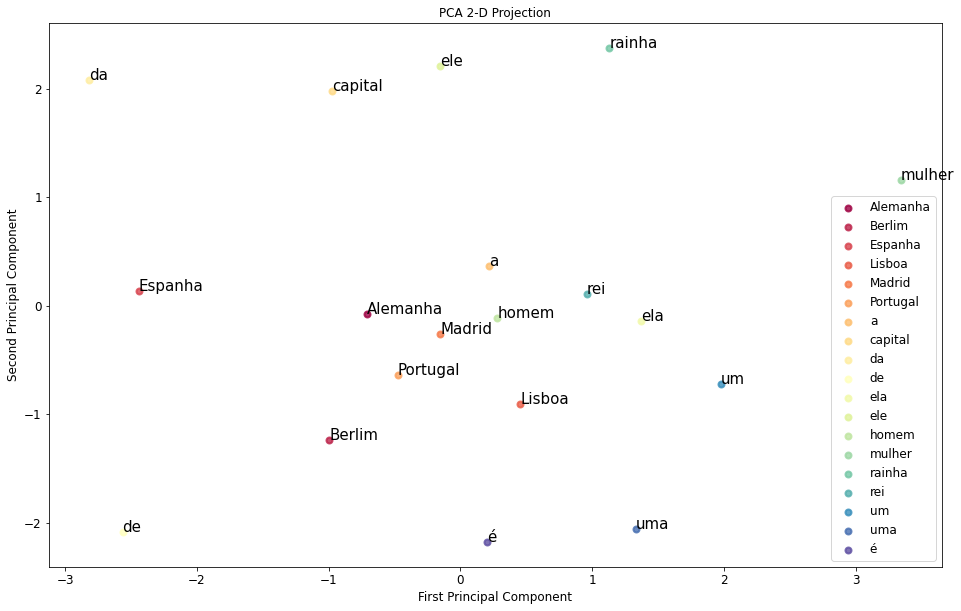

In [18]:
# Plot
ax = plot_pca_2d_projection(pca,
                            W1.data.numpy().T,
                            np.array(palavras),
                            feature_labels = palavras,
                            figsize = (16,10),
                            text_fontsize = 12)

# Legenda
for i, txt in enumerate(palavras):
    ax.annotate(txt, (proj[i,0], proj[i,1]), size = 15)


Observe a legenda no gráfico acima! Palavras similares com base no contexto, estão com a "bolinha" com cores parecidas. No topo da lista temos países e cidades, depois pronomes e a palavra "capital", temos então homem, mulher, rainha e rei e por fim artigos e um verbo.

Tudo isso foi aprendido pela rede com base no contexto, que nada mais é do que a distância de cosseno entre as embeddings, os vetores que representam as palavras.

A visualização acima mostra que palavras que estão na mesma direção possui alguma similaridade, por exemplo "Alemanha" e "Berlim". Passe uma linha reta imaginária que "corta" as palavras "Alemanha" e "Berlim". Consegue? Se a resposta for sim, as palavras são similares. Abaixo terá outro exemplo.

Vamos extrair as distâncias com base na pergunta:

# Espanha está para Madrid, assim como Alemanha está para ?

Vamos perguntar ao modelo.

In [19]:
# Função para obter um vetor de palavras no peso W1 (esse é o contexto)
def get_word_vector_v(word):
    return W1[:, word2idx[word]].data.numpy()


In [20]:
# Função para obter um vetor de palavras no peso W2 (essa é a palavra central)
def get_word_vector_u(word):
    return W2[word2idx[word],:].data.numpy()


In [21]:
# Vamos obter os vetores das palavras
espanha = 1 * get_word_vector_v('Espanha') + 1 * get_word_vector_u('Espanha')
alemanha = 1 * get_word_vector_v('Alemanha') + 1 * get_word_vector_u('Alemanha')
madrid = 1 * get_word_vector_v('Madrid') + 1 * get_word_vector_u('Madrid')

In [22]:
# Resultado
resultado = madrid - espanha + alemanha 


In [23]:
# Este é o resultado, ou seja, uma embedding que representa a palavra mais similar à palavra "Alemanha",
# com base na similaridade (contexto) entre "Polônia" e "Varsóvia".
resultado

array([ 1.0242867 ,  0.8463201 ,  0.32117316, -2.0093186 ,  2.159833  ,
       -0.8749094 , -3.925835  , -0.63879085,  2.2738745 , -0.8572308 ],
      dtype=float32)

In [24]:
# Vamos extrair as distâncias de todas as outras palavras para a nossa palavra "secreta" que está
# no vetor embedding chamado "resultado"
# Usamos a função cosine() do SciPy para calcular as distâncias
distancias = [(v, cosine(resultado, 1 * get_word_vector_u(v) + 1 * get_word_vector_v(v))) for v in palavras]


In [25]:
# Visualiza as distâncias
distancias


[('ele', 0.8449123501777649),
 ('é', 0.7771047949790955),
 ('um', 0.5612937211990356),
 ('rei', 0.9207548573613167),
 ('ela', 0.9775043353438377),
 ('uma', 1.3803388476371765),
 ('rainha', 1.4111650586128235),
 ('homem', 0.47304874658584595),
 ('mulher', 0.8113236427307129),
 ('Madrid', 0.4096205234527588),
 ('a', 0.7950792163610458),
 ('capital', 1.3378739953041077),
 ('da', 1.3228763341903687),
 ('Espanha', 1.695951223373413),
 ('Berlim', 1.0975817814469337),
 ('Alemanha', 0.8995092213153839),
 ('Lisboa', 0.8359736204147339),
 ('de', 1.1848965287208557),
 ('Portugal', 0.9544690884649754)]

Acima temos uma lista de distancias de cada palavra para nosso "resultado". Ordenando as distancias.

In [26]:
# Ordenando a lista de tuplas pelo segundo elemento da tupla
distancias.sort(key = lambda tup: tup[1])  


In [27]:
# Agora sim
distancias


[('Madrid', 0.4096205234527588),
 ('homem', 0.47304874658584595),
 ('um', 0.5612937211990356),
 ('é', 0.7771047949790955),
 ('a', 0.7950792163610458),
 ('mulher', 0.8113236427307129),
 ('Lisboa', 0.8359736204147339),
 ('ele', 0.8449123501777649),
 ('Alemanha', 0.8995092213153839),
 ('rei', 0.9207548573613167),
 ('Portugal', 0.9544690884649754),
 ('ela', 0.9775043353438377),
 ('Berlim', 1.0975817814469337),
 ('de', 1.1848965287208557),
 ('da', 1.3228763341903687),
 ('capital', 1.3378739953041077),
 ('uma', 1.3803388476371765),
 ('rainha', 1.4111650586128235),
 ('Espanha', 1.695951223373413)]

O vetor "resultado" foi uma previsão do nosso modelo e as palavras "Madrid" e "Berlim" são as mais similares. Observe que "Berlim" é a palavra mais similar com base no conexto, uma vez que Madrid já foi usada em nossa fórmula.

Imagine que um vetor (uma flecha) sai da origem do sistema de coordenadas (Honestidade = 0 e Experiência = 0, chamaremos de ponto O) e termina no ponto X. Este vetor é usado para localizar o ponto no nosso espaço de características. Não é diferente de simplesmente dizer que X possui H = 0.4 e E = 0.2, é apenas outra maneira de ver isso.

Se soubermos qual é o ângulo entre os vetores X e A, podemos usar uma calculadora simples e calcular a similaridade. Podemos ver pela imagem acima que os vetores de X e A estão sobre a mesma linha reta (observe as cores dos círculos na legenda), logo o ângulo entre eles é zero graus e sua similaridade é cos(0) = 1. Já para a similaridade entre X e B não sabemos o ângulo e precisamos usar uma equação. O numerador (a parte de cima da divisão) significa multiplicar os valores de Honestidade de X e B e somar com a multiplicação dos valores de Experiência de X e B.

Isso é o que faz o Word2vec. Brihante, não?



# Em que contexto aparece a palavra Lisboa?

Aqui é como se estivéssemos usando o modelo para previsão.

In [29]:
# Extrai o contexto
context_to_predict = get_word_vector_v('Lisboa')

# Variável com o contexto a prever
hidden = Variable(torch.from_numpy(context_to_predict)).float()

# Executa o modelo e extrai as probabilidades
# (executar o modelo nada mais é do que multiplicar os novos dados de entrada pelos pesos aprendidos no treinamento)
a = torch.matmul(W2, hidden)
probs = F.softmax(a, dim = 0).data.numpy()

# Imprime o resultado
for context, prob in zip(palavras, probs):
    print(f'{context}: {prob}')


ele: 0.00580122834071517
é: 0.4845471978187561
um: 0.0003571051638573408
rei: 0.0015697965864092112
ela: 0.0008213892579078674
uma: 0.0015300329541787505
rainha: 0.0027195618022233248
homem: 5.563299419009127e-05
mulher: 0.002593724988400936
Madrid: 0.005118111148476601
a: 0.48675990104675293
capital: 0.006895133294165134
da: 9.026716725202277e-05
Espanha: 0.0002937720564659685
Berlim: 7.930982974357903e-05
Alemanha: 4.7612658818252385e-05
Lisboa: 4.6372770157177e-05
de: 0.0006657314952462912
Portugal: 8.16377087176079e-06


O contexto da palavra "Lisboa" é representado pelas palavras "é", "a", "Portugal".

Nosso modelo não conseguiu aprender o contexto "capital". Quem sabe você consegue otimizar o treinamento do modelo e aumentar sua precisão.